In [39]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [40]:
data_dir = "C:/Users/carlab/Desktop/CV_Assignment_3/Mission_CV/DATASET 1/"
model_name = "resnext"

num_classes = 2

batch_size = 128

num_epochs = 100
feature_extract = True

In [41]:
Tr_Loss = []
Tr_Accuracy = []
Val_Loss = []
Val_Accuracy = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    for epoch in range(num_epochs):
        #scheduler.step()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['TRAIN']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'TRAIN'):
                    
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        if phase == 'TRAIN':
                            loss.backward()
                            optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'TRAIN':
                Tr_Loss.append(epoch_loss)
                Tr_Accuracy.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [42]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [44]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnext":
        """ Resnet18
        """
        model_ft = torch.hub.load('pytorch/vision:v0.6.0', 'resnext50_32x4d', pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential( 
            nn.Linear(num_ftrs, 1550),
            nn.ReLU(),
            nn.Linear(1550, num_classes),
            nn.Dropout(0.5))
        input_size = 224 
        
    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
        
    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 150
        
    elif model_name == "googlenet":
        """ GoogleNet
        """
        model_ft = torch.hub.load('pytorch/vision:v0.6.0', 'googlenet', pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

print(model_ft)

Using cache found in C:\Users\carlab/.cache\torch\hub\pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [45]:
data_transforms = {
    'TRAIN': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['TRAIN']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['TRAIN']}

image_datasets

Initializing Datasets and Dataloaders...


{'TRAIN': Dataset ImageFolder
     Number of datapoints: 22564
     Root location: C:/Users/carlab/Desktop/CV_Assignment_3/Mission_CV/DATASET 1/TRAIN
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [47]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.7)
#scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Params to learn:
	 fc.0.weight
	 fc.0.bias
	 fc.2.weight
	 fc.2.bias


In [48]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/99
----------
TRAIN Loss: 0.4600 Acc: 0.8341

Epoch 1/99
----------
TRAIN Loss: 0.2882 Acc: 0.8990

Epoch 2/99
----------
TRAIN Loss: 0.2464 Acc: 0.9084

Epoch 3/99
----------
TRAIN Loss: 0.2243 Acc: 0.9166

Epoch 4/99
----------
TRAIN Loss: 0.2121 Acc: 0.9207

Epoch 5/99
----------
TRAIN Loss: 0.2043 Acc: 0.9251

Epoch 6/99
----------
TRAIN Loss: 0.1978 Acc: 0.9263

Epoch 7/99
----------
TRAIN Loss: 0.1930 Acc: 0.9276

Epoch 8/99
----------
TRAIN Loss: 0.1883 Acc: 0.9290

Epoch 9/99
----------
TRAIN Loss: 0.1850 Acc: 0.9306

Epoch 10/99
----------
TRAIN Loss: 0.1792 Acc: 0.9320

Epoch 11/99
----------
TRAIN Loss: 0.1798 Acc: 0.9321

Epoch 12/99
----------
TRAIN Loss: 0.1808 Acc: 0.9310

Epoch 13/99
----------
TRAIN Loss: 0.1751 Acc: 0.9349

Epoch 14/99
----------
TRAIN Loss: 0.1724 Acc: 0.9347

Epoch 15/99
----------
TRAIN Loss: 0.1740 Acc: 0.9350

Epoch 16/99
----------
TRAIN Loss: 0.1700 Acc: 0.9367

Epoch 17/99
----------
TRAIN Loss: 0.1702 Acc: 0.9370

Epoch 18/99
--------

TypeError: cannot unpack non-iterable NoneType object

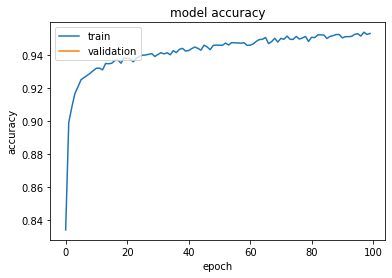

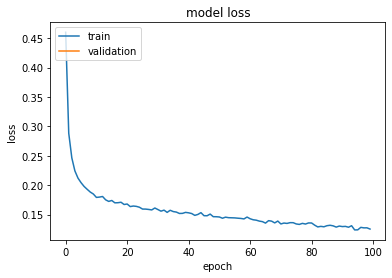

In [49]:
#Accuracy
plt.plot(Tr_Accuracy)
plt.plot(Val_Accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(Tr_Loss)
plt.plot(Val_Loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [50]:
Path = "C:/Users/carlab/Desktop/CV_Assignment_3/Mission_CV/ResnextPlus_without_Aug.pth"
torch.save(model_ft.state_dict(), Path)

In [64]:
model = model_ft.load_state_dict(torch.load("C:/Users/carlab/Desktop/CV_Assignment_3/Mission_CV/ResnextPlus_without_Aug.pth"))
model = model_ft.eval().to(device)

In [65]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [66]:
def get_predictions(model, Loader):
    A_Preds = torch.tensor([]).to(device = device)
    
    for batch in Loader:
        images, labels = batch

        images = images.to(device = device)
        labels = labels.to(device = device)
     
        pred = model(images)
        A_Preds = torch.cat((A_Preds, pred), dim = 0)
        
        return A_Preds

In [67]:
Test_Dataset = datasets.ImageFolder('C:/Users/carlab/Desktop/CV_Assignment_3/Mission_CV/DATASET 1/TEST/', transform)

In [68]:
Pred_Loader = torch.utils.data.DataLoader(Test_Dataset, batch_size = 10, shuffle=True)

In [69]:
def get_num_correct (preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [70]:
from sklearn.metrics import confusion_matrix

predlist=torch.zeros(0,dtype=torch.long).to(device)
lbllist=torch.zeros(0,dtype=torch.long).to(device)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(Pred_Loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs).to(device)
        _, preds = torch.max(outputs, 1)

        predlist=torch.cat([predlist,preds.view(-1)])
        lbllist=torch.cat([lbllist,classes.view(-1)])

conf_mat = confusion_matrix(lbllist.cpu().data.numpy(), predlist.cpu().data.numpy())

class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)

print(conf_mat)

[[1380   21]
 [ 113  999]]


In [60]:
from PIL import Image

filename = ("C:/Users/carlab/Desktop/CV_Assignment_3/Mission_CV/DATASET 1/TEST/O/O_13592.jpg")
input_image = Image.open(filename)

In [61]:
preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

input_tensor = preprocess(input_image).to(device)
input_batch = input_tensor.unsqueeze(0)
input_batch.shape

torch.Size([1, 3, 224, 224])

In [62]:
classes = 'O','R'

tensor([0.9959, 0.0041], device='cuda:0')
tensor(0, device='cuda:0')
O


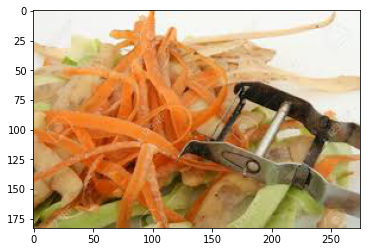

In [63]:
with torch.no_grad():
    output = model(input_batch)

per = torch.nn.functional.softmax(output[0], dim=0)
index = torch.argmax(per, dim = 0)

plt.imshow(input_image)
print(per)
print(index)
print(classes[index])